processing fold # 0
11/11 [==============================] - 0s 2ms/step - loss: 0.0518 - mae: 0.1061
Validation MAE Score: 0.10605169832706451
processing fold # 1
11/11 [==============================] - 0s 2ms/step - loss: 0.0499 - mae: 0.1006
Validation MAE Score: 0.10062384605407715
processing fold # 2
11/11 [==============================] - 0s 2ms/step - loss: 0.0564 - mae: 0.1093
Validation MAE Score: 0.10926767438650131
processing fold # 3
11/11 [==============================] - 0s 3ms/step - loss: 0.0496 - mae: 0.0963
Validation MAE Score: 0.09631813317537308


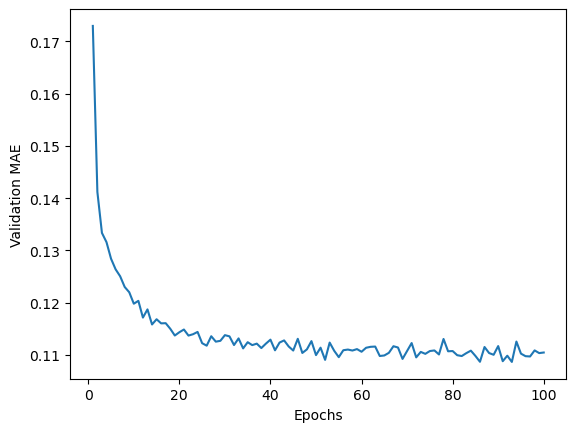

19/19 [==============================] - 0s 2ms/step - loss: 0.0547 - mae: 0.1060
Test MAE Score: 0.10599654167890549
Test MSE Score: 0.05473723262548447


In [27]:
'''
Girish Rajani-Bathija
A20503736
CS 577 - F22
Assignment 3 Regression
'''

from matplotlib import pyplot
from keras import models, layers, optimizers, losses
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.regularizers import l1_l2, l1, l2
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pandas as pd
from sklearn.model_selection import train_test_split

#Load crime dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

def load_crime_data(url):
    dataframe = pd.read_csv(url, header=None)
    dataframe = dataframe.replace('?',0)
    X = dataframe.iloc[:, :-1].drop([0, 1, 2, 3, 4], axis=1)
    Y = dataframe.iloc[:, -1]
    train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.3)
    return train_data, test_data, train_labels, test_labels

train_data, test_data, train_labels, test_labels = load_crime_data(url)

train_data = train_data.astype('float')
test_data = test_data.astype('float')

#Optimizers
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.0, decay=0.0, nesterov=False)
rmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)
adagrad = optimizers.Adagrad(learning_rate=0.01, epsilon=None, decay=0.0)
adadelta = optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adamax = optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

#Losses
mse = losses.mean_squared_error
mae = losses.mean_absolute_error
logcosh = losses.logcosh

#Build the network
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    '''model.add(BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None
))'''
    model.add(layers.Dense(1))
    model.compile(optimizer=sgd, loss=mse, metrics=['mae'])
    return model

#Perform k-fold cross validation using 4 folds
k=4
num_val_samples = len(train_data) // k
all_scores = []
all_mae_histories = []
num_epochs = 100

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_labels = np.concatenate(
        [train_labels[:i * num_val_samples],
        train_labels[(i + 1) * num_val_samples:]],
        axis=0)

    
#Train the model
    model = build_model()
    history = model.fit(partial_train_data, partial_train_labels,
    epochs=num_epochs, batch_size=10, verbose=0)
    val_mse_score, val_mae_score = model.evaluate(val_data, val_labels)
    print('Validation MAE Score:',val_mae_score)

#Record validation mean absolute error
    history_dict = history.history
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#Plot results of validation MAE on epochs
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#Evaluate on Test Data
test_mse_score,test_mae_score = model.evaluate(test_data,test_labels)
print('Test MAE Score:',test_mae_score)
print('Test MSE Score:',test_mse_score)

